# 0. Libraries

In [59]:
import warnings
warnings.filterwarnings("ignore")

# data collection
import tweepy

# preprocessing
import re
import itertools
import pandas as pd

# nlp libraries
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
import nltk

# sentiment classifiers
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# visualization
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# download dependencies

nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
# run the following line if you want to display full columns in your dataframe

pd.set_option('display.max_colwidth', -1)

# to restore display view:
# pd.reset_option('display')

# 1. Scraping Twitter

In [25]:
# add your credentials from Twitter Developer dashboard
access_token = "XXXXXXXXXXXXXXXXXX"
access_token_secret = "XXXXXXXXXXXXXXXXXX"
consumer_key = "XXXXXXXXXXXXXXXXXX"
consumer_secret = "XXXXXXXXXXXXXXXXXX"

# make OAuth Authentication and connect to Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [26]:
# collect tweets

tweets = []
max = 10000
for tweet in tweepy.Cursor(api.search,
                           q="Biden -filter:retweets",
                           count=100,
                           result_type="top",
                           include_entities=True,
                           lang="en",
                           tweet_mode="extended").items(max):

    tweets.append(tweet)

    # uncomment to see progress
    # print("{} tweets downloaded...".format(len(tweets)))

In [27]:
len(tweets)

10000

In [28]:
# save only tweet text and publication date
text = [tweet.full_text for tweet in tweets]
time = [tweet.created_at for tweet in tweets]

In [29]:
text[0]

'@SiskoBaseball @MattWalshBlog 2) Biden promised 100 million vaccination in 100 days.  That is 1 million a day, it was 900K when Trump left.\nCurrently, they are hitting 1.3 million a day, using Trumps plan.'

# 2. Sentiment Analysis

In [30]:
def light_cleaning(tweet):
    """
    Helper function to try performance on cleaned text.
    Used in this notebook for better visualization in dataframe.
    """
    # remove mentions
    tw = re.sub(r'@[_A-Za-z0-9]+', '', tweet)
    # remove hashtags
    tw = re.sub(r'#[_A-Za-z0-9]+', '', tw)
    # remove urls
    tw = re.sub(r'https?://[A-Za-z0-9./]+', '', tw)
    # remove \n
    tw = tw.replace('\n', ' ')
    # remove \
    tw = tw.replace('\\', '')

    return " ".join(tw.split()) #make sure to remove all extra whitespaces

In [31]:
def sentiment(tweets):
    """
    Get sentiment score and category with NLTK's Vader and TextBlob.

    Returns: DataFrame

        - vader_score
        - vader_category
        - textblob_score
        - textblob_category
    """
    # scores [-1, 1]
    vader_score = []
    textblob_score = []
    # categories (positive, negative, neutral)
    vader_category = []
    textblob_category = []

    for tweet in tweets:
        # Vader
        sia = SentimentIntensityAnalyzer()
        compound = sia.polarity_scores(tweet)['compound']
        vader_score.append(round(compound, 2))

        if compound >= 0.05:
            vader_category.append('positive')
        elif compound >= - 0.05 and compound < 0.05:
            vader_category.append('neutral')
        else:
            vader_category.append('negative')

        # TextBlob
        polarity = TextBlob(tweet).sentiment[0]
        textblob_score.append(round(polarity, 2))
        if polarity > 0:
            textblob_category.append('positive')
        elif polarity < 0:
            textblob_category.append('negative')
        else:
            textblob_category.append('neutral')

    return pd.DataFrame({'vader_score': vader_score, 
                         'textblob_score': textblob_score,
                         'vader_category': vader_category,
                         'textblob_category': textblob_category})

In [32]:
# get sentiment for all scraped tweets stored in text variable
sentiment = sentiment(text)

In [33]:
# prepare tweets and dates to concat with sentiment dataframe
clean = pd.Series(data=[light_cleaning(t) for t in text], name='tweet')
date = pd.Series(data=time, name='date')

In [39]:
df = pd.concat([sentiment, clean, date], axis=1)
df.head(10)

,vader_score,textblob_score,vader_category,textblob_category,tweet,date
0,0.36,0.00,positive,neutral,"2) Biden promised 100 million vaccination in 100 days. That is 1 million a day, it was 900K when Trump left. Currently, they are hitting 1.3 million a day, using Trumps plan.",2021-02-11 21:01:30
1,-0.52,-0.03,negative,negative,"starting in center and then being forced to right? what is this, the biden presidency?",2021-02-11 21:01:29
2,0.00,0.00,neutral,neutral,Biden faces mounting GOP backlash after withdrawing Trump rule on Confucius Institutes,2021-02-11 21:01:28
3,0.94,0.50,positive,positive,"I went to look that up just in case, but I saw an Instagram post of his that shows he supports Biden. :) Thank goodness.",2021-02-11 21:01:27
4,-0.62,-0.36,negative,negative,'View' co-host Meghan McCain rips Biden budget nominee Neera Tanden: One of Twitter's 'worst trolls' Explore the Fox News apps that are right for you at,2021-02-11 21:01:27
5,0.40,0.50,positive,positive,Interesting that Putin preferred Biden over Trump.,2021-02-11 21:01:27
6,0.92,0.15,positive,positive,BRAINLESS FOLLOWERS ARE DEMOCRATE &amp; BIDEN VOTER 🗽🗽🗽🗽🗽🗽🗽🗽🗽🗽 TRUMP SUPPORTERS VOTER ARE COMMON-SENSE LEADERS 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 SHEEP IN JEEPS STAND BEHIND BIDEN FREE LOVING LEADERS STAND NEXT TO TRUMP,2021-02-11 21:01:27
7,0.64,0.00,positive,neutral,Biden to announce his administration has secured 200 million additional doses promised last month,2021-02-11 21:01:27
8,0.38,0.07,positive,positive,A new way of thinking to consider...With benefits for all and possible consequences.,2021-02-11 21:01:27
9,0.79,0.00,positive,neutral,IF BIDEN HAD ANY WHITE IN HIM; HE WOULD AWARD PRESIDENT TRUMP WITH THE HIGHEST AWARD AMERICA HAS TO OFFER A PRESIDENT FOR HIS CONTRIBUTIONS IN DELIVERING NUMEROUS VACCINES TO AMERICANS AND SAVING MILLIONS OF LIVES WORLDWIDE.,2021-02-11 21:01:25


# 3. Visualizations

## 3.1 Countplot

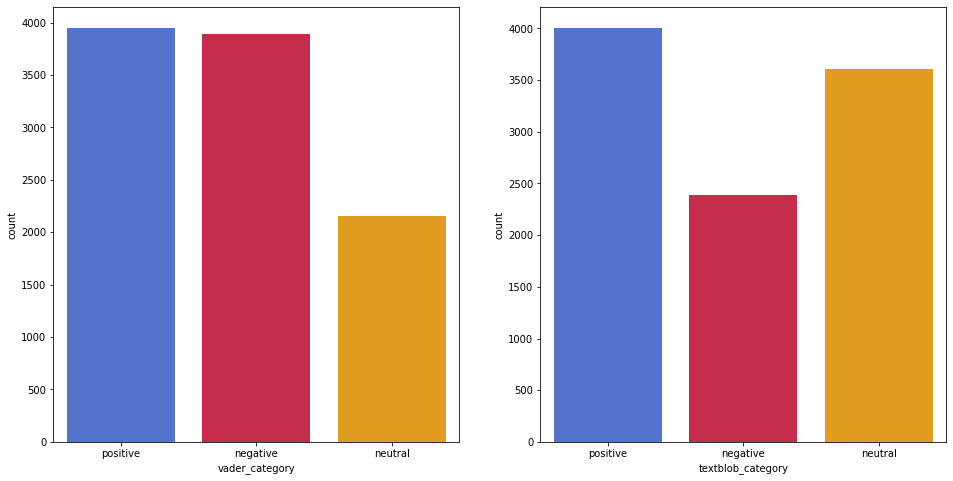

In [44]:
# plot sentiment categories as returned by Vader (left) and TextBlob (right)
fig, ax = plt.subplots(1,2, figsize=(16,8))
colors = ['royalblue', 'crimson', 'orange']
order = ['positive', 'negative', 'neutral']
vader = sns.countplot(df['vader_category'], ax=ax[0], order=order, palette=colors)
textblob = sns.countplot(df['textblob_category'], ax=ax[1], order=order, palette=colors)

## 3.2 Word clouds

In [47]:
def cleaning(tweet):
    """
    Clean text with spaCy for word cloud visualization.
    Leave only tokens with alphabetic characters, not stopwords, and lowercased.
    """
    doc = nlp(tweet.lower())
    cleaned = []
    for token in doc:
        if token.is_alpha and not token.is_stop:
            if token.pos_ != 'PRON' and not token.text == 'amp': # handling exceptions
                cleaned.append(token.lemma_)
    return cleaned

# call function on text
cleaned_text = []
for tweet in text:
    cleaned_text.append(" ".join(cleaning(tweet)))

# get indices for positive and negative tweets respectively
positives = df.vader_category == 'positive'
negatives = df.vader_category == 'negative'

def select(data, selectors):
    """
    Selects a subset of data given a list of indices.
    """
    subset = itertools.compress(data, selectors)
    final = list(itertools.chain([s for s in subset]))
    return final

# split cleaned tweets into positive and negative groups
cleaned_pos = select(cleaned_text, positives)
cleaned_neg = select(cleaned_text, negatives)

In [60]:
def words_per_type(tweets, type):
    """
    Selects only words with a given category, e.g. adjective
    or noun.
    """
    words = []
    for tweet in tweets:
        doc = nlp(tweet)
        for token in doc:
            if token.pos_ == type:
                words.append(token.text)
    return " ".join(words)

# select from positive and negative groups only adjectives or nouns

adj_pos = words_per_type(cleaned_pos, 'ADJ')
# handling exceptions
adj_pos = adj_pos.replace('biden', '')
adj_pos = adj_pos.replace('trump', '')

adj_neg = words_per_type(cleaned_neg, 'ADJ')
# handling exceptions
adj_neg = adj_neg.replace('biden', '')
adj_neg = adj_neg.replace('trump', '')

noun_pos = words_per_type(cleaned_pos, 'NOUN')
noun_neg = words_per_type(cleaned_neg, 'NOUN')

In [61]:
def plot_wordcloud(words, background):
    """
    Plot wordcloud with 50 max most common words.
    """
    plt.figure(figsize=(20, 15))
    plt.axis("off")
    wordcloud = WordCloud(width=900, 
                          height=450, 
                          random_state=1, 
                          background_color=background, 
                          colormap="Dark2",
                          max_words=50,
                          collocations=False).generate(words)
    plt.imshow(wordcloud);

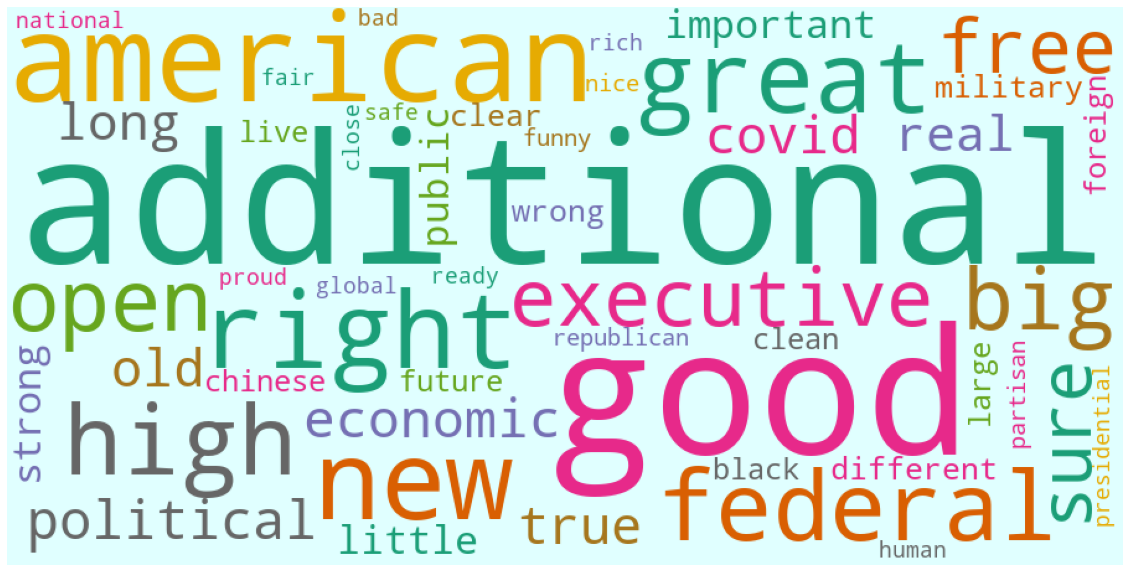

In [62]:
# plot 50 most common adjectives in positive tweets
plot_wordcloud(adj_pos, "lightcyan")

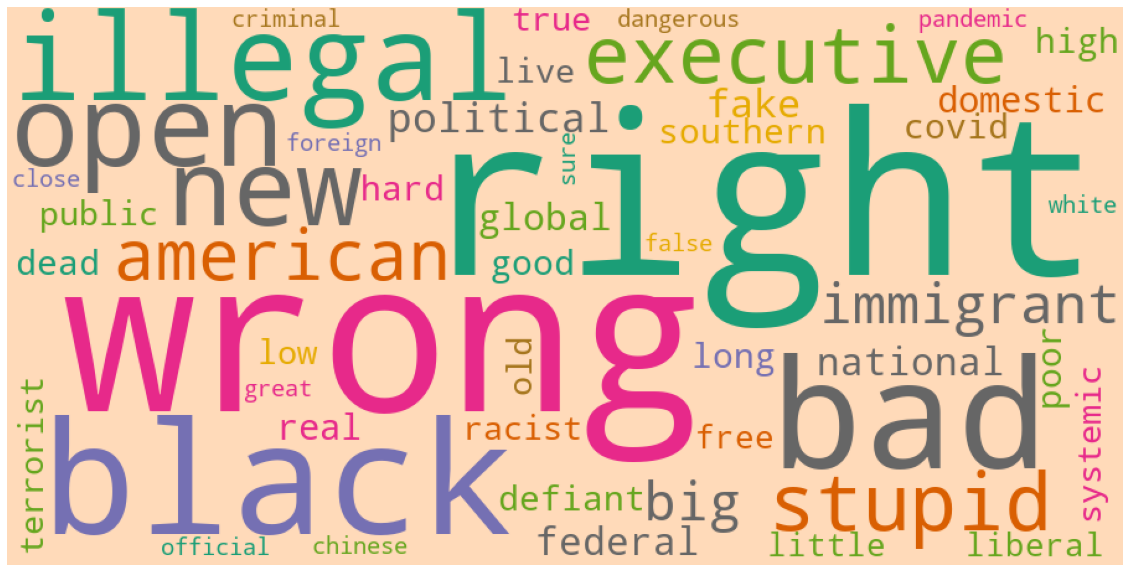

In [63]:
# plot 50 most common adjectives in negative tweets
plot_wordcloud(adj_neg, "peachpuff")

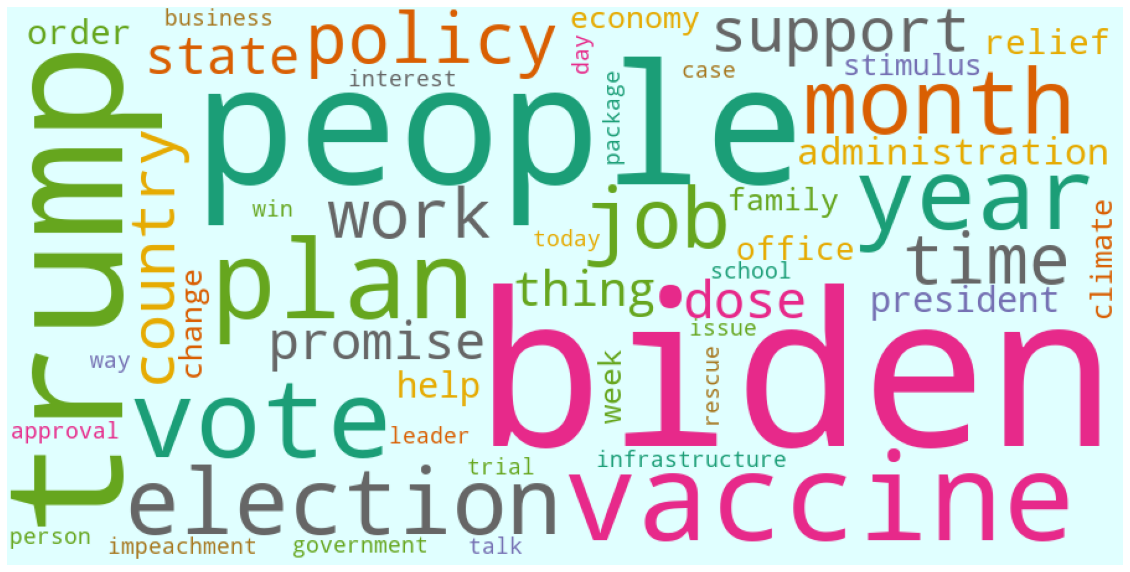

In [64]:
# plot 50 most common nouns in positive tweets
plot_wordcloud(noun_pos, "lightcyan")

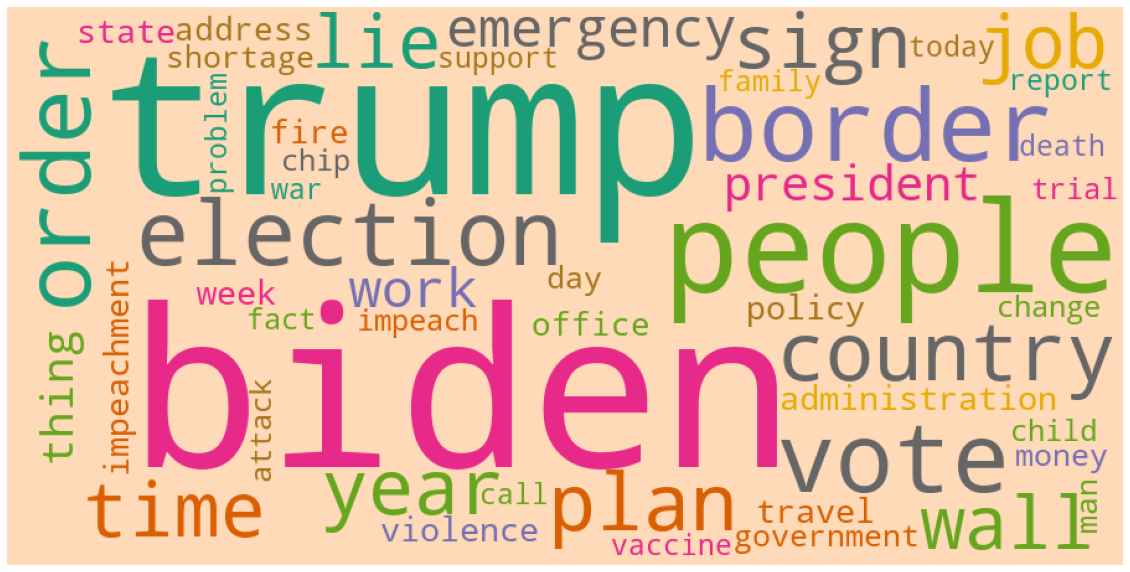

In [65]:
# plot 50 most common nouns in negative tweets
plot_wordcloud(noun_neg, "peachpuff")

In [ ]:
# FIN